# 4. Equity Risk #

While the pricing formula (3.1) is generic enough to cover just about any financial arrangement, it is most useful for fixed income instruments where the planned cash flows are highly likely. As the times and amounts in (3.1) become less and less certain, the value of enumerating possible but not probable cash flows gets lower and lower.

Thus equity risk modelers have taken other approaches to understand equity risks. In his 1900 PhD thesis at the Sorbonne, [Louis Bachelier](https://books.google.com/books?id=XcZwuHGRxsgC&pg) originated an approach to equity risk that provides the basis for most current models. His approach was essentially formula (3.60) applied to rates of return rather than to interest rates; the key insight was the use of Brownian motion ($d\beta$ in (3.60)) 5 years before Einstein's paper on the subject. For good measure Bachelier covered options pricing, anticipating by over 70 years what is perhaps the most famous formula in mathematical finance &mdash; the Black-Scholes model.

Bachelier's work was largely forgotten until it was rediscovered and promoted by the statistician Leonard Jimmie Savage in the 1950's. Whether knowingly or not, many of the models that were used by economists and financial risk modelers starting in the 1950's and 1960's used Bachelier's ideas.

In this chapter we'll discuss some of the most common equity models, starting with Harry Markowitz's efficient frontier. We'll then briefly review Bayes' Rule, and see how Bayesian adjustments are often used in practical methods to select portfolios with simultaneous risk and reward optimization.

Finally we'll show a practical and widely used method for equity risk/reward optimization, the Black-Litterman algorithm.

## 4.1 Markowitz Efficient Frontier

Harry Markowitz is considered the father of quantitative finance. In 1952, his University of Chicago PhD thesis and [subsequent work](https://www.jstor.org/stable/2975974) considered the problem of how investors should compose _portfolios_ &mdash; a portfolio is a set of assets &mdash; from individual assets.

Prior to Markowitz, investment managers who constructed portfolios had a concept that risk was something you needed to be compensated for bearing. This was compatible with Frank Knight’s formulation of risk as lack of information about the future: you needed to be paid to expose your portfolio to an unknown future. However, there was no metric for risk and therefore no precise link between how much risk you took and how much you needed to be compensated for it.

The idea that you could put a number on risk – that you could measure your lack of information about the future – is essentially due to Markowitz, who won the [1990 Nobel Memorial Prize in Economic Sciences](https://www.nobelprize.org/prizes/economic-sciences/1990/press-release/) for his work. Markowitz is still quite active – he is currently an adjunct professor at the [University of California at San Diego](https://rady.ucsd.edu/people/faculty/markowitz/).

One way of thinking of a portfolio is as an n-vector $w$ (where n is the number of all the assets in the world) that satisfies the _budget constraint_ $w^{\prime}u=1$ (u the unit n-vector of all ones). $w$ is the vector of weights of assets you own at a certain time, scaled so it represents 100% of your wealth. $w$ can contain negative values.

The _return_ or _rate of return_ on an asset during a time period is the ending value of the asset divided by the beginning value of the asset, minus one. If there are distributions such as dividends or coupons during the period, they are added (possibly in a time-adjusted way) to the ending value. The returns on the $n$ assets in the world during a period can be characterized by a random variable n-vector $r$. Thus the scalar random variable giving the return of a portfolio $w$ during the period is $w^{\prime}r$.

Markowitz introduced the idea that investors think of risk as volatility, as measured by the statistic standard deviation (or its square, variance). In our notation, standard deviation $\sigma$ of a portfolio $w$ is $\sigma=\sqrt{\mathbb{E}[\bigl(w^{\prime}(r-\mathbb{E}[r]\bigr)^2]}=\sqrt{w^{\prime}\mathbb{E}[(r-\mathbb{E}[r])(r-\mathbb{E}[r])^{\prime}]w}$. This is sensible and intuitive - there are more possibilities (less knowledge about the future) for a high-volatility series than for a low-volatility series.

Long after Markowitz, neuroscientists using functional magnetic resonance imaging (fMRI) found that human (and macaque monkey) brains seem to have built-in systems to monitor and update volatility estimates. [Behrens et. al. in 2007](https://www.nature.com/articles/nn1954) did experiments using a game where subjects needed to estimate both averages and volatilities to do better. They found
>...that human subjects assess volatility in an optimal manner and adjust decision-making accordingly. This optimal estimate of volatility is reflected in the fMRI signal in the anterior cingulate cortex (ACC) when each trial outcome is observed. When a new piece of information is witnessed, activity levels reflect its salience for predicting future outcomes

But fMRI tests are not needed to demonstrate the instinctive assessment of volatility. Consider the two time series randomly generated in Figure 4.1. The horizontal axis is time, and the vertical axis represents the time-varying value of an original dollar invested at time zero:

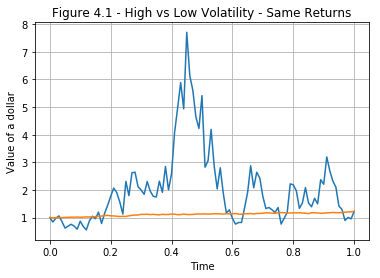

In [27]:
#Generate a high volatility and a low volatility price series
import numpy as np
import matplotlib.pyplot as plt

x=np.arange(0,1.01,.01)
r1=np.random.normal(0,.3,100)
r2=np.random.normal(0,.01,100)
#Force both series to end up in the same place
r1+=.002-np.average(r1)
r2+=.002-np.average(r2)
y1=np.append(np.array(1),np.exp(np.cumsum(r1)))
y2=np.append(np.array(1),np.exp(np.cumsum(r2)))
plt.title("Figure 4.1 - High vs Low Volatility - Same Returns")
plt.xlabel('Time')
plt.ylabel('Value of a dollar')
plt.grid()
plt.plot(x,y1)
plt.plot(x,y2);

The two time series have been forced to end up at the same place - the starting dollar at time period 0 grows to \\$1.22 at time period 1. However the blue time series is 30 times as volatile as the orange time series. If you were asked to predict where each time series would be at future time period 2, you would instinctively have much more confidence predicting that the low-volatility orange time series would continue to grow at about the same pace between period 1 and period 2 as it did between period 0 and period 1. It would be very difficult to make any prediction about where the blue series would be at time period 2.

Building on this intuition, Markowitz’s basic formulation was:
>Given a choice between two portfolios with the same expected (arithmetic) return, any rational investor will prefer the one with less risk (that is, less variance of returns).

Equivalently
>Given a choice between two portfolios with the same risk (variance of returns), any rational investor will prefer the one with more arithmetic or expected return.

Consider again the Generous Billionaires of section 1.4.2. We saw that because of risk aversion, most people would not value a coin toss for \\$1,000,000,000 or \\$0 at the average \\$500,000,000. Put another way, most people would pay far less than \\$500,000,000 to purchase a portfolio consisting of one Generous Billionaire tossing a coin for a billion or zero.

But suppose that you were able to form a portfolio of 100 coin-tossing Generous Billionaires, each tossing a different coin and paying \\$10,000,000 on heads and nothing on tails. Your best and worst cases are still one billion and zero, as they were with the single coin-tossing Generous Billionaire. But the chance of your portfolio being worth nothing is now $2^{-100}$, which is effectively zero. The outcomes of your portfolio form a binomial distribution; the chance of you getting less than \\$310,000,000 is less than $10^{-4}$. The average value of the portfolio is still \\$500,000,000. But by just about any measure, risk has gone down.

So by forming a portfolio, you get the same reward as a single coin toss, with less risk. In Markowitz's formulation, the portfolio of 100 coin-tossing billionaires is more _efficient_ than the portfolio of one coin-tossing billionaire. It has the same expected return, and lower standard deviation (\\$5 million vs. \\$500 million).

This is not just financial wizardry; _diversification_ is a better way to allocate human efforts. Pursuing 100 different ventures is a better technique for progress than everyone working on one venture, just like it was better for the farmer and the hunter in the two-person economy in section 1.5 to pool their different food-gathering efforts. 

Markowtiz's primary risk metric, standard deviation, fails the ADEH monotonicity criterion but is otherwise coherent. Actually the near-coherent risk metric is $\rho(X)=\lambda\sigma(X)-\mu(X)$, where $\lambda>0$ is a scalar and $\sigma(X)$ and $\mu(X)$ are the standard deviation and mean of $X$. Suppose $R$ and $Y$ are random variables that cost \\$1 at present. $R$ will be worth \\$1 in all future states, while $Y$ will be worth \\$1 half the time and \\$3 the other half the time. $\rho(R)=-1$ while $\rho(Y)=\lambda-2$, so the statewise dominant $Y$ shows more risk than $R$ when $\lambda$ is large enough. Thus standard deviation can say there is risk in taking advantage of the kinds of riskless arbitrages we saw in section 2.2; that's nonsense. Fortunately Markowitz's framework had few of the kinds of instruments &mdash; like derivatives &mdash; that would be the most obvious source of such arbitrage possibilities.

Once you have accepted the idea that a rational investor will choose the less risky portfolio from two with the same arithmetic mean return, you can form an _efficient frontier_: a set of portfolios that have the least possible risk at a given level of return; or the greatest possible return at a given level of risk.

Let $\boldsymbol{m}=\mathbb{E}[\boldsymbol{r}]=(\mathbb{E}[r_1],\mathbb{E}[r_2],\dots\mathbb{E}[r_n])^{\prime}$ be the vector of expected returns from now until one period in the future. Here $r_i$ is the scalar random variable giving returns of the $i^{th}$ asset and $\mathbb{E}[]$ is the expected value operator. Then $\mathbb{E}[\boldsymbol{w^{\prime}r}]=\boldsymbol{m^{\prime}w}$. Let

$$C=\begin{bmatrix}
\sigma_1^2&\sigma_{12}&\dots&\sigma_{1n}\\
\sigma_{21}&\sigma_2^2&\dots&\sigma_{2n}\\
\dots\\
\sigma_{n1}&\sigma_{n2}&\dots&\sigma_n^2\\
\end{bmatrix}\tag{4.10}$$
be the covariance matrix of returns, i.e. $\sigma_{ij}=\mathbb{E}[(r_i-\mathbb{E}[r_i])(r_j-\mathbb{E}[r_j])]$. Note we sometimes drop the double subscript on the diagonal, writing $\sigma_i^2$ instead of $\sigma_{ii}$.

Then if $\boldsymbol{w}$ is a portfolio n-vector, $Var[\boldsymbol{w^{\prime}r}]=\boldsymbol{w^{\prime}}C\boldsymbol{w}$, where Var is the variance (not value-at-risk) operator. If $\boldsymbol{w}$ is a portfolio on the efficient frontier and $\boldsymbol{v}$ is another portfolio with $\boldsymbol{w^{\prime}m=v^{\prime}m}$ (that is, they have the same expected or arithmetic mean returns), then we must have $Var[\boldsymbol{v^{\prime}r}]\geq Var[\boldsymbol{w^{\prime}r}]$. Equivalently if $Var[\boldsymbol{v^{\prime}r}]=Var[\boldsymbol{w^{\prime}r}]$ then we must have $\boldsymbol{w^{\prime}m\geq v^{\prime}m}$.

The dark blue curve on top of the dots in Figure 4.2 is the efficient frontier &mdash; you can't get any higher than that at a given point on the x axis, nor can you get any further to the left for a given point on the y axis. All the other dots represent inefficient portfolios.

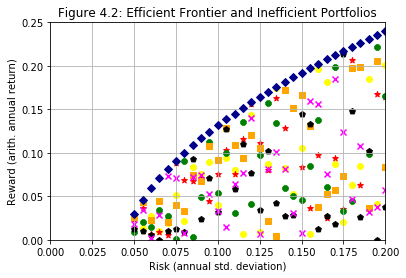

In [7]:
#Graph an efficient frontier with inefficient
#points below it
import matplotlib.pyplot as plt
import numpy as np

# evenly sampled standard deviation
t = np.arange(0.05, .2, 0.005)

#Plot the frontier
plt.plot(t, .7*(t-.04)**.5-.04, 'bD', color='darkblue')
markers=['o','*','8','s','p','x']
colors=['yellow','red','green','orange','black','magenta']
#Six sets of random inefficient portfolios
for i in range(6):
    s=np.random.uniform(0,1,len(t))
    plt.scatter(t, s*(.7*(t-.04)**.5-.04), marker=markers[i], color=colors[i])
plt.axis([0,.2,0,.25])
plt.title('Figure 4.2: Efficient Frontier and Inefficient Portfolios')
plt.xlabel('Risk (annual std. deviation)')
plt.ylabel('Reward (arith. annual return)')
plt.grid(True)
plt.show();

### 4.1.1 Equality-Constrained Frontier

Markowitz did not initially think about multiperiod portfolio construction, as that was too hard to deal with in 1952. Thus the issue of compounding and the relationship between arithmetic means and geometric (compound) means was avoided. He did not require multivariate normal distributions.

Finding an efficient portfolio n-vector $\boldsymbol{w}$ with a specified mean return $\mu$ is a quadratic optimization problem:
$$\text{Minimize  }\boldsymbol{w^{\prime}}C\boldsymbol{w}\tag{4.11}$$
$$\text{Subject to } \boldsymbol{w^{\prime}m=\mu} \text{ and } \boldsymbol{w^{\prime}u}=1$$

Of course there are many other constraints we might impose, the most obvious being non-negative holdings. In 1952, there was [only one hedge fund](http://awjones.com/legacy/) that systematically had negative holdings (short sales). Today there are far more such portfolios, but there are also many portfolios that restrict themselves to non-negative holdings.

Long-only requirements are _inequality constraints_, which don't have a closed-form solution. If we just solve the equality-constrained problem in (4.11), we can use Lagrange multipliers. We take derivates with respect to $\boldsymbol{w}$ of the Lagrangian
$$\boldsymbol{w^{\prime}}C\boldsymbol{w}-\lambda_1(\boldsymbol{w^{\prime}m}-\mu)-\lambda_2(\boldsymbol{w^{\prime}u}-1)$$
which gives
$$2C\boldsymbol{w}-\lambda_1m-\lambda_2u=0$$
If $C$ is nonsingular, we have
$$\boldsymbol{w}=C^{-1}(\lambda_1 m + \lambda_2 u)\tag{4.12}$$
where we rescale the $\lambda's$ so we can drop a factor of 2.

Left-multiplying (4.12) by $\boldsymbol{m^{\prime}}$ and $u^{\prime}$, respectively, gives
$$\mu=m^{\prime}C^{-1}(\lambda_1 m+\lambda_2 u)$$
$$1=u^{\prime}C^{-1}(\lambda_1 m+\lambda_2 u)$$

Solving for the Lagrange multipliers $\lambda_1$ and $\lambda_2$ gives
$$\lambda_1=\frac{(u^{\prime}C^{-1}u)\mu-u^{\prime}C^{-1}m}{(u^{\prime}C^{-1}u)(m^{\prime}C^{-1}m)-(u^{\prime}C^{-1}m)^2}\tag{4.13}$$
We can solve for $\lambda_2$ as a function of $\lambda_1$:
$$\lambda_2=\frac{1-(u^{\prime}C^{-1}m)\lambda_1}{u^{\prime}C^{-1}u}\tag{4.14}$$
(4.13) expresses $\lambda_1$ as a function of the desired mean return $\mu$, or $\mu$ as a function of $\lambda_1$. It will be more convenient to look at it the second way, and retain $\lambda_1$ as a varying parameter that moves along the efficient frontier. Together with (4.12), (4.13) and (4.14) give the expression for efficient portfolios $\boldsymbol{w}$ as a function of the varying parameter $\lambda_1$:
$$w=\lambda_1\bigl(I-\frac{C^{-1}J}{u^{\prime}C^{-1}u}\bigr)C^{-1}m+\frac{C^{-1}u}{u^{\prime}C^{-1}u}\tag{4.15}$$
where $J=\boldsymbol{uu^{\prime}}$ is the nxn matrix of all ones. The variance at the solution is
$$w^{\prime}Cw=\lambda_1^2\bigl(\frac{(u^{\prime}C^{-1}u)(m^{\prime}C^{-1}m)-(u^{\prime}C^{-1}m)^2}{u^{\prime}C^{-1}u}\bigr)+\frac{1}{u^{\prime}C^{-1}u}\tag{4.16}$$

If we don’t care about mean return and just want the lowest variance portfolio possible, we set $\lambda_1=0$ and get
$$w_{minv}=\frac{C^{-1}u}{u^{\prime}C^{-1}u}\text{   and   }w_{minv}^{\prime}Cw_{minv}=\frac{1}{u^{\prime}C^{-1}u}\tag{4.17}$$

(4.15) is sometimes called the _Two-Fund Separation Theorem_ because of its linear form; efficient portfolios satisfying (4.15) lie along a line in n-space. Let $w_1$ be the value of (4.15) when $\lambda_1=1$; then any $w$ on the (4.15) efficient frontier can be expressed as $w=\lambda w_1+(1-\lambda)w_{minv}$ for some $\lambda>0$. Thus in the simplified world of (4.15), investors don't have to choose between $n$ investments; every investor merely needs to buy some $w_{minv}$ and some $w_1$, with only the proportion changing from investor to investor.

If we don’t care about variance and just want the highest mean portfolio possible, there is no bound. That is because so far we have not prevented leverage, which is measured by the sum of the positive entries in $\boldsymbol{w}$.
Thus if there are two assets with slightly different expected values, we could weight the higher one with a huge weight approaching infinity, and the lower one with one minus that weight. This two-asset portfolio has an expected return approaching infinity as the weight of the higher returning asset approaches infinity and the weight of the lower returning asset approaches minus infinity.

The hedge fund Long Term Capital Management reportedly used [leverage of around 25](http://clsbluesky.law.columbia.edu/2018/09/10/a-retrospective-on-the-demise-of-long-term-capital-management/), attempting to get near-infinite returns or at least near-infinite paychecks for its principals. Since $\boldsymbol{w^{\prime}u}=1$, leverage of 25 means that for every dollar invested in LTCM, the firm borrowed another \\$24 through short sales, and put \\$25 at risk. It would only take a drop of 4% in the value of its positive holdings (while the negative holdings didn't move) to bankrupt LTCM. LTCM no longer exists and its crash in 1998 nearly destroyed the entire financial system. As a practical matter limits – on holdings, on leverage – are imposed.

Reversing (4.13) to solve for $\mu$ in terms of $\lambda_1$, we obtain
$$\mu=m^{\prime}w=\lambda_1\bigl(\frac{(u^{\prime}C^{-1}u)(m^{\prime}C^{-1}m)-(u^{\prime}C^{-1}m)^2}{u^{\prime}C^{-1}u}\bigr)+\frac{u^{\prime}C^{-1}m}{u^{\prime}C^{-1}u}\tag{4.18}$$
Taking the square root of (4.16) gives the associated standard deviation as a function of $\lambda_1$:
$$\sqrt{w^{\prime}Cw}=\sqrt{\lambda_1^2\bigl(\frac{(u^{\prime}C^{-1}u)(m^{\prime}C^{-1}m)-(u^{\prime}C^{-1}m)^2}{u^{\prime}C^{-1}u}\bigr)+\frac{1}{u^{\prime}C^{-1}u}}\tag{4.19}$$
(4.18) and (4.19) allow us to draw an efficient frontier on a graph like Figure 4.1, where the x coordinate is given by (4.19) and the y coordinate is given by (4.18) as $\lambda_1$ varies from 0 to infinity.

### 4.1.2 Equality-Constrained Frontier: Example

We'll work an example using a portfolio of $n=3$ assets: Swiss francs (CHF), pounds sterling (&pound; or GBP), and Japanese Yen (&yen; or JPY). The portfolio is denominated in US dollars.

The code in the next cell retrieves the dollar per currency for these three currencies, and reports some general statistics:

In [30]:
import pandas as pd
import qrbook_funcs as qf
#Get 3 currencies until the end of
#previous year. Form sample covariance matrix
#and do simple efficient frontier calculations

lastday=qf.LastYearEnd()
#Swiss franc, pound sterling, Japanese Yen
seriesnames=['DEXSZUS','DEXUSUK','DEXJPUS']
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,enddate=lastday)

#Convert levels to log-returns
#First take logs of the currency levels
#Currency exchange rates are usually expressed in the direction
#that will make the rate > 1
#Swissie and yen are in currency/dollar, but
#pounds is in dollar/currency. Reverse signs
#so everything is in dollar/currency

#Do each currency separately to account for separate missing data patterns
#dlgs is a list of lists of length 3 corresponding to the 3 currencies
#The value in dlgs is nan if there is missing data for the present or previous day's observation
#Otherwise it is the log of today/yesterday
multipliers=[-1,1,-1]
dlgs=[]
for i in range(len(multipliers)):
    lgrates=[]
    previous=-1
    for t in range(len(ratematrix)):
        if pd.isna(ratematrix[t][i]) or ratematrix[t][i]<=0:
            lgrates.append(np.nan)    #Append a nan
        else:
            if previous < 0:    #This is the first data point
                lgrates.append(np.nan)
            else:
                lgrates.append(np.log(ratematrix[t][i]/previous)*multipliers[i])
            previous=ratematrix[t][i]
    dlgs.append(lgrates)

#dlgs is the transpose of what we want - flip it
dlgs=np.transpose(dlgs)

#Delete any time periods that don't have data
lgdates=[]
difflgs=[]
for t in range(len(dlgs)):
    if all(pd.notna(dlgs[t])):
        #include this time period
        difflgs.append(dlgs[t])
        lgdates.append(cdates[t])

#Mean vector and covariance matrix are inputs to efficient frontier calculations
d=np.array(difflgs)
m=np.mean(d,axis=0)
c=np.cov(d.T)

#display the output
#vectors and matrices are in fractional units;
#    fraction*100=percent
#    fraction*10000=basis point
#    (fraction^2)*10000=percent^2
np.set_printoptions(precision=4)
print("Means:",m*10000,"bps/day")
print("(CHF, GBP, JPY)\n")
print("  ",c[0]*10000)
print("C=",c[1]*10000,"    (4.20)")
print("  ",c[2]*10000)
print(f'(%/day)\N{SUPERSCRIPT TWO} units')
print("  ")
print("From",lgdates[0],"to",lgdates[-1],"(",len(lgdates),"observations)")

Means: [nan nan nan] bps/day
(CHF, GBP, JPY)

   [nan nan nan]
C= [nan nan nan]     (4.20)
   [nan nan nan]
(%/day)² units
  
From 1971-01-04 to 2017-12-29 ( 12260 observations)


The Swiss franc and the Japanese yen have appreciated versus the dollar since 1971, giving positive daily mean returns. The pound sterling has depreciated.

We're going to use the means shown above as the $\boldsymbol{m}$ vector in our calculations. This is a classic, and fatal, error:
><span style="color:red">**we are estimating future characteristics by naively using past characteristics.**</span>

We want to form a portfolio today that will carry us into the future. So we want to know the _expected values_, not the past sample values, of the mean vector and covariance matrix. Past sample values might be good estimators of expected values if the processes in question were _stationary_; that is, if they had unchanging parameters (see section x.x below). But the evidence is overwhelming that financial processes are not stationary over time.

Predicting the future from the past without understanding the generating process is doomed to failure. You can jump off a 50-story building and estimate, based on past experience for the first 49 stories, that you have a 100% ability to fly. Shortly after the $49^{th}$ story on the way down you will need to revise this estimate. You need to build gravity and the density of the terrain at the base of the building into your model of your location and health.

In fact, using past performance to predict the future is legally discouraged in the US and other jurisdictions. In the US, [the Code of Federal Regulations (17 CFR 230.156)](https://www.gpo.gov/fdsys/pkg/CFR-2003-title17-vol2/pdf/CFR-2003-title17-vol2-sec230-156.pdf) says

>Representations about past or future investment performance could be misleading because of statements ... including:
<br>- (A) Representations, as to security of capital, possible future gains or income, or expenses associated with an investment;
<br>- (B) Representations implying that future gain or income may be inferred from or predicted based on past investment performance; or
<br>- (C) Portrayals of past performance, made in a manner which would imply that gains or income realized in the past would be repeated in the future. 

Of course we need to learn from the past, but often (as with jumping off a building) it’s better to bring in some kind of model (gravity is at work) to predict the future. What we really want are accurate estimates of future means and covariances. We're using past statistics in this example just because it's a convenient way to generate numbers of the right order of magnitude to illustrate the calculations. We'll say more about better estimation methods later in the chapter.

For now, we can compute the inverse of $C$ in days/pct$^2$ units:

In [45]:
#invert the c matrix, which is in (fraction/day)^2 units
#so ci (c-inverse) is in (days/fraction)^2 units
ci=np.linalg.inv(c)
print("    ",ci[0]/10000)
print(f'C\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}=',ci[1]/10000,"    (4.21)")
print("    ",ci[2]/10000)
print(f'(days/%)\N{SUPERSCRIPT TWO} units')

     [ 3.3573 -1.9558 -1.2362]
C⁻¹= [-1.9558  4.2067 -0.1417]     (4.21)
     [-1.2362 -0.1417  3.0732]
(days/%)² units


From this we can compute the key quantities $u^{\prime}C^{-1}u$, $u^{\prime}C^{-1}m$, and $m^{\prime}C^{-1}m$:


In [11]:
#sum entries in ci
uciu=np.sum(ci)
print(f'u\'C\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}u =',uciu/10000,
      f'(days/%)\N{SUPERSCRIPT TWO}')

ucim=np.sum(np.matmul(ci,m))
print(f'u\'C\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}m =',ucim,
      'days')
mcim=np.matmul(m,np.matmul(ci,m))
print(f'm\'C\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}m =',mcim*10000,
      'bps')

u'C⁻¹u = 3.969846337167373 (days/%)²
u'C⁻¹m = 0.8111878199656062 days
m'C⁻¹m = 8.79299851331195 bps


Filling in these data in equations 4.15, 4.18, and 4.19 gives the numbers for our 3-currency example portfolio. Here $\sigma=\sqrt{w^{\prime}Cw}$ is the standard deviation of the efficient portfolio $\boldsymbol{w}$:

In [12]:
#Vectors for equation 4.15
u=[1]*3
vec2=np.matmul(ci,u)/uciu
vec1=np.subtract(np.matmul(ci,m),vec2*ucim)
print(f"w'=λ\N{SUBSCRIPT ONE}",vec1,"+",vec2,"    (4.15#)")

lambdacoeff=(uciu*mcim-ucim*ucim)/uciu
constmu=ucim/uciu
print(f'μ=(λ\N{SUBSCRIPT ONE} *',lambdacoeff*10000,")+",constmu*10000," bps/day    (4.18#)")

print(f'σ=sqrt(λ\N{SUBSCRIPT ONE}\N{SUPERSCRIPT TWO} *',lambdacoeff*10000,'+',10000/uciu,') (%/day)   (4.19#)')

w'=λ₁ [ 3.9229 -5.1169  1.1939] + [0.0416 0.5313 0.427 ]     (4.15#)
μ=(λ₁ * 8.627242556185893 )+ 0.20433733476556112  bps/day    (4.18#)
σ=sqrt(λ₁² * 8.627242556185893 + 0.25189891876609405 ) (%/day)   (4.19#)


Note the vector coefficient of $\lambda_1$ in (4.15#) has total weight zero (w/roundoff), and the constant vector in (4.15#) has total weight one; it is the global minimum variance solution.

In that solution, pounds sterling (the middle coefficient) have the highest weight. From (4.20) we can see that pounds had the lowest variance, but that alone does not explain why they have the highest weight. There are also second-order effects from correlations with the other currencies. The minimum variance portfolio has a variance that is even lower than the pound's variance.

This shows that _diversification_ is a key aspect of portfolio construction – if everything were linear as it is with returns we would have only pounds in the minimum variance solution. We don’t because of the quadratic balancing act. Figure 4.3 is the classic efficient frontier graph:

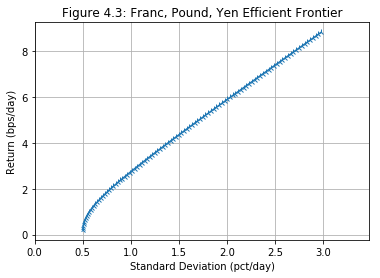

In [13]:
#Draw graph of simple efficient frontier
lambda1s=np.arange(0,1.01,.01)
xrisk=100*np.sqrt(lambdacoeff*lambda1s**2+1/uciu)   #Multiply by 100 for percent/day unites
yreturn=10000*(lambdacoeff*lambda1s+constmu)        #Multiply by 10000 for bp units

plt.figure(1)
plt.plot(xrisk,yreturn,marker='2')
plt.title("Figure 4.3: Franc, Pound, Yen Efficient Frontier")
plt.xlabel("Standard Deviation (pct/day)")
plt.ylabel("Return (bps/day)")
plt.xlim(0,max(xrisk)+.5)
plt.grid()
plt.show();

The global minimum variance portfolio in this example has positive weights as we saw in (4.15#). From the negative middle entry in the vector multiplying $\lambda_1$ in (4.15#), we can see that the weight of the pound will go negative as $\lambda_1$ gets larger:

In [14]:
print(f'Pound weight goes negative at λ\N{SUBSCRIPT ONE}=',-vec2[1]/vec1[1])
print('At that point μ=',-10000*lambdacoeff*vec2[1]/vec1[1]+10000*constmu,' bps/day')
print('and σ=',10000*np.sqrt(lambdacoeff*(vec2[1]/vec1[1])**2+1/uciu),' bps/day')

Pound weight goes negative at λ₁= 0.10383748372997502
At that point μ= 1.1001684933280618  bps/day
and σ= 58.72987077443066  bps/day


### 4.1.3 Inequality Constraints

Then as $\lambda_1\rightarrow\infty$, we borrow more and more pounds to fund investments in francs and yen, heading off to an infinite expected return. I stopped Figure 4.3 at $\lambda_1=1$, but it could keep going.

But letting $\lambda_1$ get arbitrarily large isn't a sensible thing to do. If we start with a dollar, borrow a billion dollars worth of pounds and buy a billion and one dollars of francs&yen, then the slightest disturbance in the relationships between francs, yen and pounds will bankrupt us. We can’t treat our estimated means and covariances as certainties and place infinite reliance on their accuracy.

Even if they were certain, we would have an absorbing barrier problem in the interim. That is, we can't have a net worth below zero; that's the definition of bankruptcy. We can draw a line on a graph that starts at \\$1, meanders down to -\\$0.10, and ends up at (positive) \\$3. But in reality, as soon as the line goes below zero, the entity represented by the line &mdash; a company, a fund, an investment &mdash; is bankrupt and will stop operating. That's similar to an absorbing barrier in physics, where a particle can meander only up to the point where it hits the sides of a container.

The mean-variance efficient frontier problem is often specified with the additional constraint that all weights must be non-negative. This changes the problem from one that can be solved in closed form to one that can be solved using a quadratic programming algorithm:
$$\text{Minimize } -\lambda m^{\prime}w + \frac{1}{2}w^{\prime}Cw$$
$$\text{Subject to } w^{\prime}u=1 \text{, each element of } w\geq0\tag{4.22}$$
In addition to the non-negative constraint, we have restated the problem slightly by building in a parameter $\lambda$ instead of a target mean $\mu$. This is the same idea as flipping (4.13) to (4.18). When $\lambda=0$, we solve for the global minimum variance portfolio. As $\lambda$ increases, we care more and more about return maximization and less and less about variance minimization. Thus $\lambda$ is a risk tolerance parameter &mdash; something like $-\frac{u^{\prime}}{u^{\prime\prime}}$ as seen in section 1.4.3.

The solution to the long-only optimization (4.22) is a piecewise series of solutions to the equality-constrained frontier (4.18) and (4.19). In the Franc/Pound/Yen frontier, for example, the equality-contrained minimum variance portfolio has all positive weights so it is also a solution to (4.22). The frontiers continue to coincide until the weight on the pound sterling goes to zero. Then the solution to (4.22) is the efficient frontier consisting only of the Swiss franc and the Japanese yen, shown in orange in Figure 4.4 below. Eventually the Swiss franc (the highest-returning single asset) becomes the whole portfolio and the (4.22) long-only frontier stops.

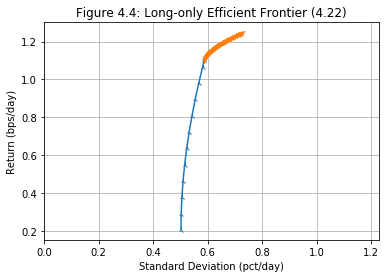

In [15]:
#Draw graph of long-only efficient frontier
#Segment with pounds
lambda_nopound=-vec2[1]/vec1[1]
lambda1s=np.arange(0,lambda_nopound,.01)
lambda1s=np.append(lambda1s,lambda_nopound)
x1=100*np.sqrt(lambdacoeff*lambda1s**2+1/uciu)   #Multiply by 100 for percent/day units
y1=10000*(lambdacoeff*lambda1s+constmu)        #Multiply by 10000 for bp units

#Get franc/yen portfolio at the point where pounds disappear
vec3=lambda_nopound*vec1+vec2
#rest of frontier decreases yen and increases francs
x2=[]
y2=[]
deltas=np.arange(0,vec3[2]*1.01,vec3[2]/100.)
for delta in deltas:
    newvec=vec3+[delta,0,-delta]
    y2.append(10000*np.matmul(newvec,m))
    x2.append(100*np.sqrt(np.matmul(np.matmul(newvec,c),newvec)))

plt.figure(1)
plt.plot(x1,y1,marker='2')
plt.plot(x2,y2,marker='1')
plt.title("Figure 4.4: Long-only Efficient Frontier (4.22)")
plt.xlabel("Standard Deviation (pct/day)")
plt.ylabel("Return (bps/day)")
plt.xlim(0,max(x2)+.5)
plt.grid()
plt.show();

### 4.1.4 Efficient Frontier and Utility Functions

The connection between portfolios that maximize utility functions and portfolios on the Markowitz efficient frontier is close but not perfect. For example, [L. B. Pulley, "Mean-Variance Approximations to Expected Logarithmic Utility"](https://www.jstor.org/stable/170783) concludes
>...investors maximizing expected logarithmic utility would hold virtually the same portfolios as investors maximizing certain mean-variance functions.

Similarly in a 1984 paper, [Kroll, Levy and Markowitz](https://www.jstor.org/stable/2327667) concluded
>for various utility functions and the historical returns on 3 different sets of securities, when a portfolio may be chosen from any of the infinite number of portfolios of the standard constraint set, the best mean-variance efficient portfolio has almost maximum obtainable expected utility.

One way of making the connection between utility functions and the Markowitz efficient frontier objective function is to consider a quadratic one-period risk-averse utility function on returns, i.e. one that looks like $u(z)=-z^2+az$, $a>0$. The coefficient of absolute risk aversion is $2/(a-2z)$ so this is risk-averse when $z<a/2$. That is, $u(z)$ “likes” more return for a while, but if the shock is too big (negative or positive), it gets unhappy.

The investor wants to maximize the expected utility of returns:
$$\mathbb{E}[u(r^{\prime}w)]=\mathbb{E}[-(r^{\prime}w)^2+a\cdot r^{\prime}w]=-w^{\prime}\mathbb{E}[rr^{\prime}]w+aw^{\prime}\mathbb{E}[r]$$
where $r$ is the random vector of one-period returns. We have already defined the mean vector $m=\mathbb{E}[r]$ and the covariance matrix $C=\mathbb{E}[(r-m)(r-m)^{\prime}]$. Thus
$$C=\mathbb{E}[rr^{\prime}-2rm^{\prime}+mm^{\prime}]=E[rr^{\prime}]-mm^{\prime}$$

So we have
$$\mathbb{E}[u(r^{\prime}w)]=-w^{\prime}Cw-(w^{\prime}m)^2+aw^{\prime}m$$

This is similar to the Markowitz objective function (4.22) (with $a=2\lambda$ and a change of sign) &mdash; although the covariance matrix is not de-meaned.

### 4.1.5 The Capital Market Line

The _capital market line_ is derived from the efficient frontier by the addition of a risk-free asset, i.e. a US Treasury or other instrument paying the risk-free rate that we discussed in Chapter 3. We assume the risk-free asset is nonstochastic, so it has no variance and no correlation with anything, including itself.

We can look for an efficient frontier in the usual way and just add the risk-free asset to our universe. However this will make our covariance matrix singular. The usual convention is to separate out the risk-free asset, which has a return $r_f$. For example, consider the franc, yen, pound efficient frontier. We zoom in to the beginning of the frontier and add a risk-free asset at (0,.1), i.e. $r_f=.1$bps/day.

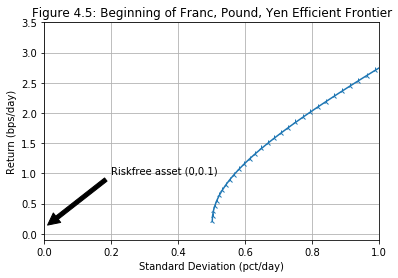

In [17]:
#Add a risk-free asset at .1 bps/day
rfrate=10**(-5)
plt.figure(2)
plt.plot(xrisk,yreturn,marker='2')
plt.title("Figure 4.5: Beginning of Franc, Pound, Yen Efficient Frontier")
plt.xlabel("Standard Deviation (pct/day)")
plt.ylabel("Return (bps/day)")
plt.xlim(0,1)
plt.ylim(-.1,3.5)
plt.annotate('Riskfree asset (0,'+str(10000*rfrate)+')', xy=(0, 10000*rfrate),
             xytext=(.2, 1),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.grid()
plt.show();

We can now be more efficient than the (old) efficient frontier. A straight line that runs between the risk-free asset at $(0,r_f)$ and some point $(x,y)$ that is on the efficient frontier where $y\geq r_f$ will lie above the efficient frontier until $(x,y)$. That line just represents linear combinations of the efficient portfolio at $(x,y)$ and a portfolio consisting only of the risk-free asset.

In fact if we choose the tangency point where the slope of the line from $(0,r_f)$ to the efficient frontier just touches the top of the frontier, the will always be above the frontier. That optimal line is the new (including risk-free) efficient frontier and is called the _capital market line_. The two-fund separation theorem that we saw in formula (4.15) now becomes even simpler: the new efficient portfolios are linear combinations of the risk-free asset and the tangency portfolio.

To compute the capital market line, note that equations (4.18) and (4.19) specify the old efficient frontier; (4.18) is the y coordinate and (4.19) is the x coordinate. Taking the slope with the chain rule, we see that $\frac{dy}{dx}=\frac{x}{\lambda_1}$. For tangency, this slope must equal $\frac{y-r_f}{x}$, which is the slope of the line between $(x,y)$ and the risk-free asset’s representation.

Solving for $\lambda_1$ gives $\lambda_1=\frac{1}{u^{\prime}C^{-1}m - r_f(u^{\prime}C^{-1}u)}$. Putting this $\lambda_1$ into (4.12) gives the tangency portfolio $w_{tp}$:
$$w_{tp}=\frac{C^{-1}(m-r_f u)}{u^{\prime}C^{-1}m - r_f(u^{\prime}C^{-1}u)}=\frac{C^{-1}m_e}{u^{\prime}C^{-1}m_e}\tag{4.30}$$
where $m_e$ is the excess (over riskfree) return vector $m_e=m-r_f u$.

A portfolio $w$’s _Sharpe Ratio_ is $\frac{w^{\prime}m-r_f}{\sqrt{w^{\prime}Cw}}$, i.e. its excess expected mean return divided by its standard deviation. Note that in the mean/standard deviation graphs we have been drawing, the slope of a line that goes through the point $(0,r_f)$ is the Sharpe ratio of portfolios on that line. Thus the maximum Sharpe ratio efficient portfolio is the tangency portfolio; to see this, visualize the set of lines from $(0,r_f)$ to points on the efficient frontier.

The tangency (best efficient Sharpe ratio) portfolio has an excess expected return equal to
$$w_{tp}^{\prime}m_e=\frac{m_e^{\prime}C^{-1}m_e}{u^{\prime}C^{-1}m_e}\tag{4.31}$$
and a standard deviation
$$\sqrt{w_{tp}^{\prime}Cw_{tp}}=\frac{\sqrt{m_e^{\prime}C^{-1}m_e}}{u^{\prime}C^{-1}m_e}\tag{4.32}$$
Thus the Sharpe ratio of the tangency portfolio is
$$Sharpe(w_{tp})=\sqrt{m_e^{\prime}C^{-1}m_e}$$

If we go back to our currency example and add a risk-free asset with $r_f=.1$bp/day, the tangency portfolio looks like this:

In [18]:
#Print the tangency portfolio
rfvec=[rfrate]*3
tangencyport=np.matmul(ci,m-rfvec)/(ucim-rfrate*uciu)
print('Tangency portfolio:',tangencyport)
#Solve for the lambda1 at tangency
mutp=np.matmul(tangencyport,m.T)
sigmatp=np.sqrt(np.matmul(np.matmul(tangencyport,c),tangencyport.T))
tpl1=(mutp-constmu)/lambdacoeff
print('TP μ=',mutp*10000,' bps/day')
print('TP σ=',sigmatp*100,' pct/day')
print(f"λ\N{SUBSCRIPT ONE} at tangency:",tpl1)

Tangency portfolio: [  9.5126 -11.8222   3.3096]
TP μ= 21.032865078157474  bps/day
TP σ= 7.1089853529744005  pct/day
λ₁ at tangency: 2.4142740403719696


Drawing the line between the riskfree rate on the y axis and the tangency portfolio gives the orange capital market line in Figure 4.6:

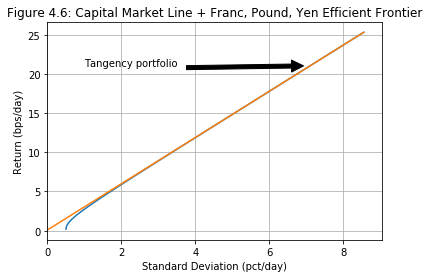

In [19]:
#Show capital market line
#Extend frontier
lambda1s=np.arange(0,tpl1+.5,.01)
xrisk=100*np.sqrt(lambdacoeff*lambda1s**2+1/uciu)
yreturn=10000*(lambdacoeff*lambda1s+constmu)

#Compute line
x=np.arange(0,max(xrisk),.01)
y=100*((mutp-rfrate)/sigmatp)*x+10000*rfrate

plt.figure(3)
plt.plot(xrisk,yreturn)
plt.plot(x,y)
plt.annotate('Tangency portfolio', xy=(sigmatp*100, mutp*10000),
             xytext=(1,mutp*10000),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.title("Figure 4.6: Capital Market Line + Franc, Pound, Yen Efficient Frontier")
plt.xlabel("Standard Deviation (pct/day)")
plt.ylabel("Return (bps/day)")
plt.xlim(0,max(xrisk)+.5)
plt.grid()
plt.show;

The efficient frontier in Figure 4.6 is near-linear by the time the capital market line touches it, so there is little difference between the capital market line and the original efficient frontier in this example. When the efficient frontier has more nonlinear shape &mdash; for example as a result of multiple constraints &mdash; there can be more separation between the capital market line and the efficient frontier

### 4.1.6 Benchmark-Relative

As a practical matter, many investment vehicles are constrained to invest in certain segments of the capital markets. For example, a mutual fund may advertise that it is a "large-cap US equity fund." Investors who favor big US companies can give a sum of money to the mutual fund manager, and the manager will decide which big US companies to buy with that money. The manager would be amiss &mdash; and legally culpable &mdash; if it didn't mostly[$^1$](#four_footnotes) invest its investors' money in big US companies; to do otherwise would be false advertising. By the same token, investors can hardly blame the manager if big US stocks generally do poorly; they knew what they were getting into.

This situation is usually handled with a _benchmark portfolio_. Benchmark portfolios are often constructed by institutions that publish transparent benchmark composition rules intended to select certain market segments mechanically. For example, the FTSE/Russell company publishes the [Russell 1000&reg;](https://www.ftse.com/products/indices/russell-us) index of the one thousand largest stocks in Russell's universe; this is widely used as a large-cap US equity benchmark.

Risk is then redefined to be relative to the benchmark $b$; in our example $b=$Russell 1000&reg;, which itself would be considered to have no risk, while cash would have quite a lot of risk. Rather than $\sqrt{w^{\prime}Cw}$, the relevant volatility would be $\sqrt{(w-b)^{\prime}C(w-b)}$; this benchmark-relative volatility is called _tracking error_. The objective function in an optimization like (4.22) would change to $-\lambda m^{\prime}(w-b) + \frac{1}{2}(w-b)^{\prime}C(w-b)$.

### 4.1.7 Efficient Frontiers: Theory and Practice

While Markowitz started the field of quantitative finance and his work was revolutionary, investors quickly found that it often didn’t work as well as the qualitative methods they were using before 1952. One problem is that the quadratic optimization process doesn’t know that the numbers (means, covariances) it is given can be wrong. While a human would be skeptical about large, too-good-to-be-true returns, the optimization process is likely to put a heavy weight on a security with a too-good-to-be-true return.

Even realistic returns can lead to unrealistic results. A human would think that the difference between two securities, both with very similar covariances to the rest of the universe, and one with a mean of 1.12345 and the other 1.12346, was random. It wouldn't make much difference if you were buying one or the other. But as we noted in section 4.1.1, if you're buying one and selling the other, then any small difference between securities can be exploited with enough leverage. An unconstrained optimizer would go massively long the higher return one and massively short the lower, thereby multiplying random estimation errors.

In fact most of our currency example efficient frontier was highly leveraged and would be unattainable with the long only constraint; most of the “results” could be suspect. Thus, as we’ve already noted, in many cases holdings are constrained to be long only; this stops solutions from having any leverage. 

Despite the problems with naively using past statistics to predict the future, past (sample) covariance matrices are often used to estimate expected covariances. In fact a great deal of effort has been spent on understanding how covariances change over time; we'll discuss these efforts in Chapters x and y below. But covariances are less variable than sample mean returns. So there are a number of estimation methods that start with sample covariance matrices and then try to modify them so they are better predictors.

Sample covariance matrices are, by construction, at least positive semidefinite and possibly positive definite. We need $n$ time periods of observation to make an $n\times n$ covariance matrix nonsingular, but even if we have that many periods we still might not have a rich set of data for each entry. There are $n+1\choose 2$ different numbers in a covariance matrix. In every time period we observe $n$ rates of return. So if we have $t$ periods of observations, the number of observables per covariance is $\frac{2t}{n+1}$. For example, for the Russell 1000&reg; index, we would need 5005 time periods if we wanted to have a not very impressive ten observations per covariance.

5005 observations is about twenty years at a daily periodicity, which limits the number of companies that can be considered, as many do not have public trading data for that long. Too, daily observations are only valid for the most heavily traded stocks; a lightly traded stock may not have any meaningful trading activity after (say) 2PM, while more heavily traded stocks continue trading (and reacting to news) until 4PM. The day's return on the lightly traded stock is then asynchronous with the day's returns on more heavily traded stocks. That in turn can lead to misleadingly low correlations. Longer periodicities, like monthly, are often used to address this problem. A few hours of missing price movements out of a month is less noticeable than a few hours missing from a day. But at a monthly periodicity, any sample covariance matrix of the Russell 1000&reg; will be singular. That in turn causes problems with solving optimizations as in (4.12), which will no longer have a unique solution.

Even when covariance matrices aren't singular, they can have problems. The _condition number_ of a matrix is the ratio of its largest eigenvalue to its smallest eigenvalue. The larger the condition number, the more likely it is that a very small change in input variables (means and covariances) can make a very large change in output variables (weights of the optimal solution). 

Because of the generally poor quality of covariance matrices, most users of optimizers put bounds on many quantities in addition to long-only (or not-too-short) constraints. Individual holdings usually have concentration limits – e.g. no single stock can occupy more than 5% of the portfolio. If the optimization is benchmark-relative, then constraints like “every security must be within plus or minus 2% of the benchmark’s weight in that security" can be set. Constraints are often placed on other relevant characteristics like industries, countries, property types (in real estate portfolios), and duration/credit quality (in fixed income portfolios).

Setting limits produces sensible portfolios, since the limits are set sensibly. But in effect it gives the answer to the optimizer – if the user is not careful, an optimizer can become a [smokescreen for the judgments of the human who put in very restrictive limits](https://www.jstor.org/stable/4479185)

## 4.2 Review of Bayes' Rule

We'll now turn our attention to some of the practical approaches to estimating the parameters $m$ and $C$ used in the construction of efficient portfolios. Many of them rely on Bayes' Rule, which we'll now briefly review.

Bayes' Rule is simple to state:
$$Pr(E\mid F)=\frac{Pr(F\mid E)Pr(E)}{Pr(F)}$$
It is essentially a restatement of the definition of conditional probability in section 1.6. Despite this uncomplicated derivation, Bayes' Rule is profound. We'll walk through an example to get an intuitive feel for Bayes' Rule.

Suppose you suspect you have a rare disease that makes you forget your personal utility function. Fortunately there's a very accurate test for this condition. You go to the doctor and take the test, which comes back positive. You are now terrified that if you should run into some generous billionaires (as in section 1.4.2), you won't know what to do. You contemplate entering an intensive (and expensive) treatment program for the condition. Should you?

We need to be more precise: by "rare," we mean that only one in ten thousand people has the disease. And by "very accurate," we mean that the test is right 99% of the time.

The relevant outcome space $\Omega$ in this case is the set of roughly 7.5 billion people in the world. $\Omega$ can be divided into four disjoint events:
- People with positive test results who have the disease;
- People with positive test results who don't have the disease;
- People with negative test results who have the disease; and
- People with negative test results who don't have the disease.

From the $10^{-4}$ probability of having the disease, we know that 750,000 people in the world have the disease. This allows us to start filling in a table:

| Outcomes |  Have Disease |  Don't Have |  Total  |
|----------|:-------------:|------------:|:-------:|
| Test+    |               |             |         |
| Test-    |               |             |         |
| Total    |  750,000      | ~7.499Bn    |  7.5Bn  |

Of the 750,000 who have the disease, 99% are properly diagnosed and 1% (7,500) are misdiagnosed as not having the disease. Similarly for the 7.499Bn who don't have the disease. So we can completely fill in the table:

| Outcomes |  Have Disease |  Don't Have   |     Total     |
|----------|:-------------:|--------------:|:-------------:|
| Test+    |  742,500      |  74,992,500   |   75,735,000  |
| Test-    |    7,500      | 7,424,257,500 | 7,424,265,000 |
| Total    |  750,000      | 7,499,250,000 | 7,500,000,000 |

With a positive test result, you are in the Test+ row. But the vast majority of people with a positive test score are test mistakes in the "don't have" column. In fact even with a positive test result, your chance of having the disease is only 1%.

If $n=|\Omega|$ is the size of the outcome space, then we know
- Event E (have disease) has size $10^{-4}n=750,000$.
- Event W (wrong test result) has size $10^{-2}n=75,000,000$
- Event F (positive test result) has size $(10^{-2}+10^{-4}-2\cdot10^{-6})n=75,735,000$   
Event F's size is not directly given but is computed from the first row of the 2x2 matrix.

| Outcomes |  Have Disease | &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Don't Have &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;                            | &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;     Total     |
|----------|:-------------:|------------------------------------:|:--------------------:|
| Test+    |  $E\cap F$    |  $(\Omega\setminus E)\cap F$                     |   $F$  |
| Test-    | $E\cap (\Omega\setminus F)$      |                 $(\Omega\setminus E)\cap (\Omega\setminus F)$     | $\Omega\setminus F$
| Total    |  $E$      | $\Omega\setminus E$                     | $\Omega$ |

In terms of probabilities, $p_E=10^{-4}$ is the probability of having the disease, and $p_W=10^{-2}$ is the probability of a wrong test result. Then the table looks like:

| Outcomes |  Have Disease | &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Don't Have &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;                            | &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    Total     |
|----------|:-------------:|------------------------------------:|:--------------------:|
| Test+    |  $p_E(1-p_W)$    |  $(1-p_E)p_W$                     |   $p_F=p_E+p_W-2p_E p_W$  |
| Test-    | $p_Ep_W$      |                 $(1-p_E)(1-p_W)$     | $1-p_E-p_W+2p_E p_W$
| Total    |  $p_E$      | $1-p_E$                     | $1$ |

In our example, we wanted to know the probability of having the utility-forgetting disease (event E) given that we had observed a positive test result (event F). Event E is called the _prior_ – what you believed to be true before new information came in. So you believed that the chance of having utility-forgetting disease was very small (.01%) before taking the test.

Event F is the _update_: a positive test result. As we saw, from the fact that the test is wrong $p_W=.01$ of the time and the fact that $p_E=10^{-4}$, we could compute $p_F=p_E+p_W-2p_E p_W=.010098$. The conditional probability $Pr(F\mid E)$=probability positive test result given you have the disease is 99% because the test is 99% accurate independently of whether or not you have the disease. Putting it together, we get $Pr(E\mid F)$=probability of disease given positive test result$=.99*.0001/.010098=.009804$, or a little less than 1% as we saw.

Bayes Theorem is due to Thomas Bayes, who lived from 1701-1761. It is far ahead of its time in its clever use of existing information (e.g. utility-forgetting-disease is rare); new information (test results); and probability theory. This is especially clever because probability theory, at least as we know it today, didn’t exist in the early 1700’s. Of course the general concept of odds, such as in the Bernoullis’ discussion of St. Petersburg paradox, existed then. But the formal framework including sample spaces, σ-algebras, and probability measures was a few hundred years in the future.

### 4.2.1 Shrinkage Estimators

Practitioners often use methods intended to improve parameter estimates, sometimes in conjunction with proprietary views on the future direction of markets. Many such methods take the form of _shrinkage estimators_. The general idea is similar to Bayes’ Rule: we have some kind of prior belief about a quantity we are trying to estimate, and we “shrink” the deviations from the prior in some way. Often the prior is _centralized_, meaning it is based on some kind of marketwide average value.

An example of a centralized prior for an efficient portfolio is the vector $w=\frac{1}{n}u$; which indicates that everything in the universe is of equal importance without knowing anything about means and covariances. [Bouchard, Potters & Aguilar](https://arxiv.org/abs/cond-mat/9707042)[$^2$](#four-footnotes) had this prior in mind when they suggested maximizing a nonparametric portfolio diversification measure like entropy:
$$\exp\bigl(-\sum{w_i\cdot ln(w_i)}\bigr)$$
or an inverse [Herfindahl-Hirschman](https://www.jstor.org/stable/1818582) index
$$\frac{1}{\sum{w_i^2}}=\frac{1}{w^{\prime}w}$$
Here $w_i$ are the scalar components of the portfolio vector $w$, where as usual $w^{\prime}u=1$. For both metrics, the worst case is the intuitively most concentrated: one $w_i=1$ and the others equal to zero. Both measures equal one in that case. If $w\geq 0$, then for both measures the best case (where the measures equal $n$) is $w_i=1/n$ (in vectors, $w=\frac{1}{n}u$).

The Bouchard, Potters & Aguilar suggestion was to add one of the diversification measures to the portfolio optimization problem, so for example the objective in (4.22) would be changed to
$$\text{Minimize } -\lambda m^{\prime}w + \frac{1}{2}w^{\prime}\bigl(C+\gamma I\bigr)w\tag{4.40}$$
With a sufficiently large $\gamma$ parameter, the optimization will focus more on minimizing the nonparametric Herfindahl-Hirschman Index, and less on the quantities $m$ and $C$ that need estimating. This can produce a solution that mitigates the problem of too-heavy reliance on random noise in inputs, pushing solutions toward $w=\frac{1}{n}u$.

The problem of parameter estimation is so large that some have suggested giving up on it altogether. [DeMiguel, Garlappi, and Uppal 2007](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=911512) considered the "1/N rule," which in our notation means forming the portfolio $w=\frac{1}{n}u$ &mdash; the same as giving infinite weight to the $\gamma$ parameter in (4.40). DeMiguel et. al. evaluated out-of-sample performance of a number of variations on parameter estimation for Markowitz-type mean-variance optimization. They
>find that none is consistently better than the 1/N rule in terms of Sharpe ratio, certainty-equivalent return, or turnover. This finding indicates that, out of sample, the gain from optimal diversification is more than offset by estimation error... This suggests that there are still many "miles to go" before the gains promised by optimal portfolio choice can actually be realized out of sample. 

For example, the [_James-Stein shrinkage estimator_](http://digitalassets.lib.berkeley.edu/math/ucb/text/math_s4_v1_article-19.pdf) for the vector of multivariate normal means can be applied to the prior belief that all means are equal to some common scalar value $\mu_0$. The observed mean vector $m$ is then pushed some way back to this prior. A scalar $s$ is used to calibrate how far to push back:
$$s=\min\bigl(1,\frac{n-2}{T(m-\mu_0u)^{\prime}C^{-1}(m-\mu_0u)}\bigr)\tag{4.41}$$
where $n$ is the number of variables in the vectors and $T$ is the number of observations (often time periods). The revised mean vector estimate is then
$$m_{new}=(1-s)m+s\mu_0u\tag{4.42}$$
The default mean $\mu_0$ can for example be the average of all the means in m ($\mu_0=\frac{m’u}{n}$).

This seems like a sensible, quasi-Bayesian, heuristic for not relying too much on possibly erroneous sample data. But James and Stein showed something remarkable about this estimator: if there is a true (but unknown) population mean vector $m_{true}$, then
$$(m_{true}-m)^{\prime}C^{-1}(m_{true}-m)\geq(m_{true}-m_{new})^{\prime}C^{-1}(m_{true}-m_{new})\tag{4.43}$$
That means that in some sense, the new estimator is guaranteed to be closer to the unknown true mean vector than the original. That's _for any value of $\mu_0$_! So you can just pick a $\mu_0$ randomly and you'll get closer to the true mean vector than your sample mean vector $m$. Of course an outrageous $\mu_0$ will cause the $s$ in (4.41) to be very small, so there won't be much adjustment. But it will be in the right direction!

A similar idea is seen in the [_Jorion shrinkage estimator_](https://www.jstor.org/stable/2331042), formed by taking
$$s=\frac{n+2}{n+2+T(m-\mu_{min})^{\prime}C^{-1}(m-\mu_{min})}\text{, where }\mu_{min}=\frac{m^{\prime}C^{-1}u}{u^{\prime}C^{-1}u}\tag{4.44}$$
and then applying the shrinkage combination in (4.42). Note that $\mu_{min}$ is the return on the global minimum variance portfolio we obtained in the original equality-constrained version of the Markowitz efficient frontier, i.e. the value of (4.18) when $\lambda_1=0$.

We can similarly apply shrinkage estimators to the covariance matrix. In a 1978 paper, [Elton & Gruber](https://www.jstor.org/stable/2326368) pointed out that there appeared to be little information in covariance matrices off the diagonal, and suggested just setting every correlation to the same value. They were reluctant to do this, saying
>In this section, we will assume that all pairwise correlation coefficients are equal. While this probably does not represent the true pattern one finds in the economy, it is very difficult to obtain a better estimate. Elsewhere we have shown that this assumption produces better estimates of future correlation coefficients than do historical correlation coefficients...

This was later refined by [Ledoit and Wolf in 2003](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=433840) as a shrinkage process with a constant-correlation prior. Let $R=S^{-1}CS^{-1}$, where $C$ is a samnple covariance matrix and $S=\sqrt{diag(C)}$ is the matrix with sample standard deviations on the diagonal and zeroes elsewhere. $R$ is the sample correlation matrix. Let $\rho_{average}=\frac{u^{\prime}Ru-n}{n(n-1)}$ be the average off-diagonal correlation. Then the constant correlation covariance matrix is
$$C_{\rho}=S(I+\rho_{average}(J-I))S$$
where as usual $J=uu^{\prime}$ is the matrix of all ones.

The Ledoit-Wolf covariance shrinkage estimator is
$$C_{new}=sC_{\rho}+(1-s)C\tag{4.46}$$
where s is a scalar shrinkage parameter – the larger s is, the less trust you have in your correlations. Ledoit and Wolf give the following rather elaborate estimate of $s$:
- First, define $y_{it}$ as the de-meaned observation of the $i^{th}$ security's return in time period $t$, so that $\sum_t y_{it}=0$. Then if $Y$ is the sample de-meaned return matrix ($n\times T$), then $C=\frac{1}{T}YY^{\prime}$ is the sample covariance matrix.
- Second, define $f_{ij}$ as the $(i,j)$ element of $C_{\rho}$ and $s_{ij}$ as the (i,j) element of $C$.
- Third, compute $\hat{\pi}=\sum_i\sum_k\pi_{ij}$ where $\pi_{ij}=\frac{1}{T}\sum_{t=1}^T\bigl(y_{it}y_{jt}-s_{ij}\bigr)^2$
- Fourth, compute $\hat{\nu}_{ii,ij}=\frac{1}{T}\sum_{t=1}^T\bigl(y_{it}^2-s_{ii}\bigr)\bigl(y_{it}y_{jt}-s_{ij}\bigr)$. Then compute $\hat{x}=\sum_{i=1}^n\pi_{ii}+\frac{\rho_{average}}{2}\sum_{i=1}^n\sum_{j=1,j\neq i}^n\bigl(\sqrt{\frac{s_{jj}}{s_{ii}}}\hat{\nu}_{ii,ij}+\sqrt{\frac{s_{ii}}{s_{jj}}}\hat{\nu}_{jj,ij}\bigr)$
- Fifth, compute $\hat\gamma=\sum_{i=1}^n(f_{ij}-s_{ij})^2$
- Sixth, set $s=\frac{\hat{\pi}-\hat{x}}{\hat{\gamma}}$. Ledoit and Wolf suggest bounding this between 0 and 1 if necessary.

While this estimate of the optimal shrinkage intensity $s$ is quite complicated to write down, it is not hard to program. An easier heuristic is to set $s$ equal to the fraction of the trace contained in the correlation matrix’s first $\sqrt{n}$ eigenvalues.

### 4.2.3 Resampled Efficient Frontier

Shrinkage techniques deal with estimation error in means and covariances, but not directly with finding the portfolios on the efficient frontier. In 1992, [Philippe Jorion](https://www.jstor.org/stable/4479507) addressed the problem of finding efficient frontiers directly with the following procedure:
>1. Compute the means and covariance matrix from the actual sample of historical returns. Define T as the sample size (number of months, say) and N as the number of assets. Perform the optimization, given the stated objective function and investor constraints.
>2. Assume that the estimates from Step 1 are true values. From a multivariate standard normal distribution with these parameters, draw one random sample of N joint returns. This represents one month of simulated returns. Sample again until T months are generated.
>3. Estimate from these simulated returns a new set of means and a new variance-covariance matrix; perform an optimization using these inputs. The simulated optimal portfolio provides one observation in the distribution of the original optimal portfolio.
>4. Repeat Steps 2 and 3 until the distribution of the optimal portfolio is approximated with enough precision.

We can follow Jorion's procedure to see how much ambiguity there is in the minimum-variance portfolio $\frac{C^{-1}u}{u^{\prime}C^{-1}u}$ from our three-currency example:

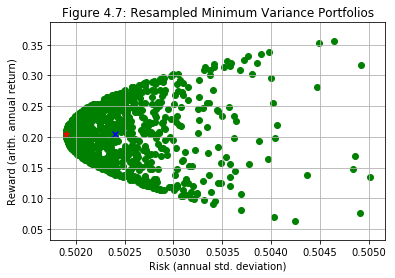

In [20]:
#Resample the minimum variance portfolio from 3-currency example
samp_size=1000
samp_time_periods=1000
samp_stds=[]
samp_means=[]
samp_portfolios=[]
for trial in range(samp_size):
    #Generate a virtual history of returns in x
    x=np.random.multivariate_normal(m,c,samp_time_periods)
    #Compute the virtual history's mean, covariance, and inverse covariance
    samp_m=np.mean(x,axis=0)
    samp_c=np.cov(x.T)
    samp_ci=np.linalg.inv(samp_c)
    #Compute minimum variance portfolio s_vec2 according to new parameters
    s_uciu=np.sum(samp_ci)
    s_vec2=np.matmul(samp_ci,u)/s_uciu
    #Find the mean and standard deviation of this portfolio according to the old parameters
    samp_means.append(10000*np.matmul(s_vec2,m))
    samp_stds.append(100*np.sqrt(np.matmul(np.matmul(s_vec2,c),s_vec2)))
    samp_portfolios.append(s_vec2)

#Plot the minimum variance portfolios 
plt.scatter(samp_stds,samp_means,marker='o',color='green')
#Plot the original MV portfolio
plt.scatter(np.sqrt(10000./uciu),10000.*ucim/uciu,marker='*',color='red')
#Plot the average of the resampled MV portfolios
plt.scatter(np.mean(samp_stds),np.mean(samp_means),marker='x',color='blue')
#Zoom in on the x-range
xdiff=np.max(samp_stds)-np.min(samp_stds)
plt.xlim(np.min(samp_stds)-.05*xdiff,np.max(samp_stds)+.05*xdiff)
plt.title('Figure 4.7: Resampled Minimum Variance Portfolios')
plt.xlabel('Risk (annual std. deviation)')
plt.ylabel('Reward (arith. annual return)')
plt.grid(True)
plt.show();

There's a very large range of mean returns of the resampled minimum variance portfolio shown in Figure 4.7. The standard deviations (x-axis) are less variable, but even they show not only a range, but also an inevitable upward bias. The red marker is the original minimum variance portfolio, which is the only efficient portfolio on the graph according to the original parameters. The blue marker is the average of the sample characteristics, which is riskier than the original minimum variance portfolio. The difference between the blue marker and the red marker is an indication of how overly optimistic we were about our ability to get a low-variance portfolio.

There's also uncertainty about the weights. We can compute a 95% confidence interval for them from the sample:

In [21]:
#Show the 95% confidence intervals for the MV portfolio    
bottom=np.percentile(samp_portfolios,5,axis=0)
middle=np.percentile(samp_portfolios,50,axis=0)
top=np.percentile(samp_portfolios,95,axis=0)
print("95% confidence for MV portfolio:")
print("Bottom of interval: ",bottom)
print("Middle of interval: ",middle)
print("Original MV port:   ",vec2)
print("Top of interval:    ",top)

95% confidence for MV portfolio:
Bottom of interval:  [-0.004   0.4851  0.3838]
Middle of interval:  [0.0423 0.5309 0.4274]
Original MV port:    [0.0416 0.5313 0.427 ]
Top of interval:     [0.0895 0.5771 0.4683]


Typically we see that zero is in the confidence interval for the first (Swiss franc) weight, so we're not even sure we should have any in the minimum variance portfolio. The range of pound sterling (second) and Japanese yen (third) weights are typically about 8% wide. And the minimum variance portfolio is generally the most stable since it doesn't use the mean vector as an input!

A _resampled efficient frontier_ takes this resampling process and averages it to get a collection of optimal mean-variance portfolios that, it is hoped, will have less dependence on sampling noise. One way of averaging was proposed by Richard Michaud[$^3$](#four_footnotes) in 1998; Michaud has a [US patent](https://patents.google.com/patent/US6003018A/en) on this method, which is offered commercially through the firm [New Frontier Advisors](https://www.newfrontieradvisors.com/).

Michaud aggregates the minimum variance portfolios from each sample as we did above. He then chops the remainder of the efficient frontier from the minimum variance to the maximum return &mdash; assuming there is a maximum return &mdash; into an equal number of steps. For example suppose the original frontier had a minimum return of .2 and a maximum of 2 and there were 10 steps desired along the frontier; then 10 efficient portfolios $P_{1,0}$ with return .2; $P_{2,0}$ with return .4; ...; and $P_{10,0}$ with return 2 would be recorded. Then a resampled frontier would be generated for simulation 1; say its minimum and maximum returns were .15 and 2.88. The compositions of the 10 portfolios $P_{1,1}$ with return .15; $P_{2_1}$ with returns .47; ...; and $P_{10,1}$ with return 2.88 would be recorded. The resampled frontier would then consist of the 10 portfolios $\frac{1}{S+1}\sum_{s=0}^S P_{i,s}$ 

The Michaud method essentially aggregates resampled portfolios by target mean. Another method is offered by [Morningstar/Ibbotson](https://corporate.morningstar.com/Fib/documents/MethodologyDocuments/ResearchPapers/RobustAssetAllocation.pdf) which essentially aggregates by target standard deviation; their description is:
>Ibbotson uses a proprietary "bin approach," in which asset allocations from the _simulated_ portfolios are grouped together based on narrowly defined standard deviation ranges that cover the risk spectrum. The average asset allocations are then linked back to the original inputs to plot the resampled efficient frontier.

Whichever method is used, the general idea is to (a) lower and (b) estimate sampling noise through a process of resampling. [Bernd Scherer](https://www.jstor.org/stable/4480438) points out that resampling methods will average out to the original efficient frontier when there are no constraints in the optimization process, but when there are constraints - for example, long-only holdings - the resampled frontier will generally improve on the original frontier. That is, empirical tests have generally shown that resampled frontiers do better at predicting out-of-sample (future) behavior than the original efficient frontier. But resampling is a heuristic rather than a proof, and practitioners continue to search for even better heuristics to predict out-of-sample behavior.


## 4.3 Black-Litterman

[Black-Litterman](http://jfi.iijournals.com/content/1/2/7) is another attempt to deal with poor estimation of the Markowitz parameters, in this case through a Bayesian framework. "Black" is Fischer Black, whose contributions to mathematical finance include (among many others) the Black-Scholes option pricing formula and two of the models in section 3.8.4. "Litterman" is Robert Litterman, who headed quantitative management at Goldman Sachs Asset Management and who we have already seen in the Litterman-Sheinkman paper in section 3.5.5. 

In the Black-Litterman framework, we assume there is a true but unobservable expected mean vector $\mu$ that is associated with the process generating asset returns. Before updating our information to estimate $\mu$, we have a prior belief: namely that it is consistent with the Capital Asset Pricing Model, which we will cover in section 5.1. The prior that comes from that model is:
$$\mu_{CAPM}=r_f u + (\mathbb{E}[r_M]-r_f)\beta\tag{4.70}$$
where $r_M$ is the scalar random variable giving returns on the market, and $\beta$ is an n-vector giving the beta of each of the $n$ assets in the market.

Our error of estimate is given by a multivariate normal distribution with mean 0 and covariance matrix $sC$, where $s$ is a confidence scalar. If s=0, we are perfectly confident that $\mu_{CAPM}$ is the right answer. As s gets larger, we get less confident. $C$ might be estimated from historical returns or from an equity model. Note however that a full covariance matrix $C$ is not consistent with the CAPM, which assumes $C=\sigma_M\beta^{\prime}\beta$.

In the Black-Litterman framework, we can express views (opinions) about the actual mean return n-vector $\mu$. A view is a value of some linear combination of returns. The simplest view is that a return on a particular asset will take on a particular value, but we can also (for example) express a view on an industry (a weighted combination of the assets in that industry), or on one group of assets versus another (a hedge or relative value trade). In general, we write
$$p=V\mu+\epsilon\tag{4.71}$$
where V is a $v\times n$ matrix whose rows are the linear combinations expressing the form of our views, of which we have v. p is a v-vector giving the outcomes of the views. $\epsilon$ is an error v-vector with mean 0.

For example, if we believe pharmaceutical stocks will outperform energy stocks by 12%, a row of $V$ would have positive weights (perhaps capitalization-weighted) on all the pharmaceutical stocks and negative weights on energy stocks, and the corresponding row of the v-column-vector $p$ would be 12%.

We are trying to minimize the error term $\epsilon$ on the right-hand side. To do this, we could solve a standard ordinary least squares (OLS) regression using least squares, obtaining $\mu=(V^{\prime}V)^{-1}V^{\prime}p$. However in accordance with our theme of keeping track of how much we don’t trust our parameters, we assume that the error vector $\epsilon$ is multivariate normally distributed with mean 0 and $v\times v$ covariance matrix $\Gamma$. The smaller the entries of $\Gamma$, the more confident we are in our views. Usually we assume off-diagonal elements are 0, and that really is just to make things easier.

When we have an error matrix like $\Gamma$, we can use an extension of ordinary least squares regression called generalized least squares (GLS). The idea is to modify OLS regression by weighting the variables we are more sure about more heavily, and the variables we are less sure about less heavily. The GLS solution is
$$\mu_{views}=(V^{\prime}\Gamma^{-1}V)^{-1}V^{\prime}\Gamma^{-1}p\tag{4.74}$$

We have two equations involving our estimate of $\mu$ – one from the CAPM (4.70) and one from views (4.74). We can put them together and minimize the errors using GLS again. We put everything together into these vectors:
$$y=\left( {\begin{array}{c}
   \mu_{CAPM} \\
   p \\
  \end{array} } \right);
M=\left( {\begin{array}{c}
   I \\
   V \\
  \end{array} } \right);
E=\left( {\begin{array}{cc}
   sC & 0 \\
   0 & \Gamma \\
  \end{array} } \right)\tag{4.75}
$$
Plugging the quantities in (4.75) into a GLS like (4.74) gives
$$\mu=\left(\frac{1}{s}C^{-1}+V^{\prime}\Gamma^{-1}V\right)^{-1}\left(\frac{1}{s}C^{-1}\mu_{CAPM}+V^{\prime}\Gamma^{-1}V\mu_{views}\right)\tag{4.76}$$
Recall that $s$ is the scalar that shows how much we disbelieve the prior &mdash; the CAPM view. As $s\rightarrow 0$, the views become less and less important and the estimate of $\mu$ approaches $\mu_{CAPM}$. On the other hand, as $s\rightarrow\infty$, the CAPM prior becomes less and less important and the views dominate, giving $\mu_{views}$ when the expressions make sense.

In this case – when the matrices are well-behaved enough – we can write
$$\mu=M_{CAPM}\mu_{CAPM}+(I-M_{CAPM})\mu_{views}\text{, where}$$
$$M_{CAPM}=\left(\frac{1}{s}C^{-1}+V^{\prime}\Gamma^{-1}V\right)^{-1}\frac{1}{s}C^{-1}\text{  and}\tag{4.77}$$
$$M_{views}=\left(\frac{1}{s}C^{-1}+V^{\prime}\Gamma^{-1}V\right)^{-1}V^{\prime}\Gamma^{-1}V\text{   so}$$
$$M_{CAPM}+M_{views}=I$$
However note that $M_{CAPM}$ is affected by the views, and $M_{views}$ is affected by the CAPM. In fact views do not only affect the securities for which they are expressed – they are spread out over the entire vector. This reflects the fact that a view on a security passes through the covariance structure and affects other securities.

### 4.3.1 Black-Litterman Example

We'll work an example of Black-Litterman, using our currency data from earlier in the chapter. For currencies, the concept of "the market" is not as clear as it is for stocks. It's relatively easy to compute the total value of investable shares of Apple Computer or Walmart; it's less easy to compute the total value of investment we could make in Swiss francs. We'll just arbitrarily assign a market portfolio for our three currencies:
$$w_M=\left( {\begin{array}{c}
   .05 \\
   .15 \\
   .80 \\
  \end{array} } \right)\tag{4.78}$$

Then from our previous data we can compute the expected mean return $m^{\prime}w_M$ of the market, and the market's standard deviation $\sqrt{w_M^{\prime}C w_M}$:

In [247]:
#Fake "market" for the three currencies
wmkt=np.array([.05,.15,.8])
mumkt=np.matmul(wmkt,m.T)
varmkt=np.matmul(np.matmul(wmkt,c),wmkt.T)
print('Mkt μ=',mumkt*10000,' bps/day')
print(f'Mkt σ\N{SUPERSCRIPT TWO}=',varmkt*10000,f'(%/day)\N{SUPERSCRIPT TWO}')

Mkt μ= 0.77126153179715  bps/day
Mkt σ²= 0.3288651118758403 (%/day)²


We can also compute the vector of betas of the three individual assets with the market, and from that the $\mu_{CAPM}$ vector given by (4.70):

In [248]:
betavec=np.matmul(c,wmkt)/varmkt
print('β =',betavec)

mucapm=rfvec+(mumkt*10000-rfrate)*betavec
print('μCAPM=',mucapm,' bps/day')

β = [0.7401 0.49   1.1119]
μCAPM= [0.5708 0.3779 0.8575]  bps/day


Let us now put in a single opinion, which is that pounds will outperform yen by .2bps/day. The CAPM prior says pounds will underperform yen, so we are going in a different direction. In the notation of (4.71) this says
$$p=.00002$$
$$V=\left( {\begin{array}{ccc}
   0& 1& -1 \\
  \end{array} } \right)$$

Let us assume the error of estimate matrix of our views is $\Gamma=.0001\cdot I$, where I is the identity matrix (actually a scalar here since v=1). We’ll weight our market beliefs with $s=1$.

We can then compute the term
$$\left(\frac{1}{s}C^{-1}+V^{\prime}\Gamma^{-1}V\right)^{-1}$$
used in (4.76) and (4.77):

In [254]:
#View that pounds will outperform yen
view=np.array([0,1,-1])
pview=.00002

gamma=np.matrix([.0001])
sweight=1

#First Black-Litterman matrix calculation
print('C\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}/s=',
      ci/sweight)
#Second matrix
v1=np.matmul(np.matrix(view).T,np.linalg.inv(gamma))
vgvmtrx=np.matmul(v1,np.matrix(view))
print('V\'Γ\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}V=',vgvmtrx)
#Sum of the two
print('Sum=',ci/sweight+vgvmtrx)

m1inv=np.linalg.inv(ci/sweight+vgvmtrx)
print('Sum inverse (x10000)=',m1inv*10000)

C⁻¹/s= [[ 33572.8682 -19557.5649 -12362.3658]
 [-19557.5649  42067.0075  -1416.7783]
 [-12362.3658  -1416.7783  30732.0058]]
V'Γ⁻¹V= [[     0.      0.     -0.]
 [     0.  10000. -10000.]
 [    -0. -10000.  10000.]]
Sum= [[ 33572.8682 -19557.5649 -12362.3658]
 [-19557.5649  52067.0075 -11416.7783]
 [-12362.3658 -11416.7783  40732.0058]]
Sum inverse (x10000)= [[0.527  0.2483 0.2296]
 [0.2483 0.3216 0.1655]
 [0.2296 0.1655 0.3616]]


The other terms are $\frac{1}{s}C^{-1}\mu_{CAPM}$ and $V^{\prime}\Gamma^{-1}V\mu_{views}$. Note from (4.74) we have $V^{\prime}\Gamma^{-1}V\mu_{views}=V^{\prime}\Gamma^{-1}p$:

In [258]:
cimcs=np.matmul(ci,mucapm/sweight)*10**(-4)
print('Cinv*muCAPM/s=',cimcs)

print('V\'Γ\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}p=',v1*pview)
m2=cimcs+v1.T*pview
print('Sum=',m2)

Cinv*muCAPM/s= [0.1173 0.3518 1.8762]
V'Γ⁻¹p= [[ 0. ]
 [ 0.2]
 [-0.2]]
Sum= [[0.1173 0.5518 1.6762]]


Multiplying the matrix times the vector gives the Black-Litterman estimate $\mu$ as in (4.76):

In [259]:
mufinal=np.matmul(m1inv,m2.T)*10000
print('Black-Litterman μ:',mufinal)

Black-Litterman μ: [[0.5836]
 [0.484 ]
 [0.7243]]


After a great deal of calculation, we have modified the $\mu_{CAPM}$ vector a little: the expected mean pound return has increased and the expected mean yen return has decreased, although not enough to fully implement our opinion that pounds would outperform yen by .2bps. The expected return on Swiss francs has changed a little too, even though we didn't have an opinion about it: this is because of the covariance structure causes our views to propagate through to the entire market.

Recall that we had some uncertainty parameters &mdash; the scalar $s$ and the matrix $\Gamma$ &mdash; that have no obvious calibration process. A Black-Litterman user can adjust them until they give an answer that seems intuitively appealing. The danger is similar to that of overconstraining an optimization &mdash; we adjust a quantitative process until it confirms our qualitative biases.  [Michaud, Esch, and Michaud](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2641893) captured this concern in the title of their 2013 paper: "Deconstructing Black-Litterman: How to get the portfolio you already knew you wanted."

Still, such quantitative methods are not without value. A careful analyst will focus on listening to the algorithm rather than telling it what to do. For example, understanding what relationships caused the change in the Swiss franc's expected return in our Black-Litterman example might lead to some insight: what is it about the pound's and the yen's relationships with the franc that caused that movement? Is there some relationship between the Swiss, British, and Japanese economies that is being revealed, or is it just a statistical artifact? Pursuing these kinds of questions can lead to better results.

<a name="four_footnotes"></a>
# Chapter 4 Footnotes

$^1$In the US, "mostly" means [80% or more](https://www.sec.gov/rules/final/ic-24828.htm)
<br>

$^2$Bouchard, Potters & Aguilar are physicists who now run a quantitative hedge fund in Paris (www.cfm.fr).
<br>

$^3$ The father-and-son team of Richard Michaud and Robert Michaud wrote _Efficient Asset Management: A practical Guide to Stock Portfolio Optimization and Asset Allocation_ in 1998; the second edition is from 2008 and is published by Oxford University Press, ISBN 978-0-19-533191-2.